In [67]:
# Import libraries and load the dataset

import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("heart_disease_uci.csv")

# Display first few rows
data.head()


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [68]:
# Basic information and stats
data.info()
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  target    920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


,id,age,trestbps,chol,thalch,oldpeak,ca,target
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [69]:
# Explore target variable distribution
data['target'].value_counts()




target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [70]:
# Check for missing values
data.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

In [71]:
# Handle Missing Data (Numeric + Categorical, Proximity-based)
from sklearn.impute import KNNImputer

# Make a copy of the data to work safely
df = data.copy()

# Step 1 — Drop columns with excessive missingness (>50%)
df = df.drop(columns=['thal','ca','slope','dataset'])  # too many NaNs and unneccesary columns

# Step 2 — KNN Imputation for numeric features
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Initialize imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
df_numeric_imputed = pd.DataFrame(knn_imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# Replace numeric columns with imputed values
df[numeric_cols] = df_numeric_imputed

# Proximity-based + fallback imputation for categorical columns
def fill_categorical_mode_with_fallback(df, target_col, group_cols):
    # Group-based fill using mode (proximity)
    df[target_col] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
    )
    # Fallback global mode if still missing
    if df[target_col].isnull().any():
        global_mode = df[target_col].mode().iloc[0]
        df[target_col].fillna(global_mode, inplace=True)
    return df

# Handle remaining categorical columns manually
# These are known categorical / binary columns in Heart dataset
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang']

# Apply proximity-mode imputation
df = fill_categorical_mode_with_fallback(df, 'fbs', ['sex'])
df = fill_categorical_mode_with_fallback(df, 'restecg', ['sex'])
df = fill_categorical_mode_with_fallback(df, 'exang', ['sex', 'cp'])

# Verify all missing values handled
print("Missing values per column after cleaning:\n")
print(df.isnull().sum())

# Final clean dataset
data_cleaned = df.copy()




Missing values per column after cleaning:

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
target      0
dtype: int64


C:\Users\kshit\AppData\Local\Temp\ipykernel_5436\364866250.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x
C:\Users\kshit\AppData\Local\Temp\ipykernel_5436\364866250.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x


In [72]:
# Perform one-hot encoding for categorical variables
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_cols, drop_first=True)

# Display new shape and head
data_encoded.shape, data_encoded.head()


((920, 15),
     id   age  trestbps   chol  thalch  oldpeak  target  sex_Male  \
 0  1.0  63.0     145.0  233.0   150.0      2.3     0.0      True   
 1  2.0  67.0     160.0  286.0   108.0      1.5     2.0      True   
 2  3.0  67.0     120.0  229.0   129.0      2.6     1.0      True   
 3  4.0  37.0     130.0  250.0   187.0      3.5     0.0      True   
 4  5.0  41.0     130.0  204.0   172.0      1.4     0.0     False   
 
    cp_atypical angina  cp_non-anginal  cp_typical angina  fbs_True  \
 0               False           False               True      True   
 1               False           False              False     False   
 2               False           False              False     False   
 3               False            True              False     False   
 4                True           False              False     False   
 
    restecg_normal  restecg_st-t abnormality  exang_True  
 0           False                     False       False  
 1           False        

In [73]:
# Converting target variable into binary classes
# 0 = No heart disease, 1 = Any level of heart disease

data_encoded['target'] = (data_encoded['target'] > 0).astype(int)

# Confirming the distribution

data_encoded['target'].value_counts()



target
1    509
0    411
Name: count, dtype: int64

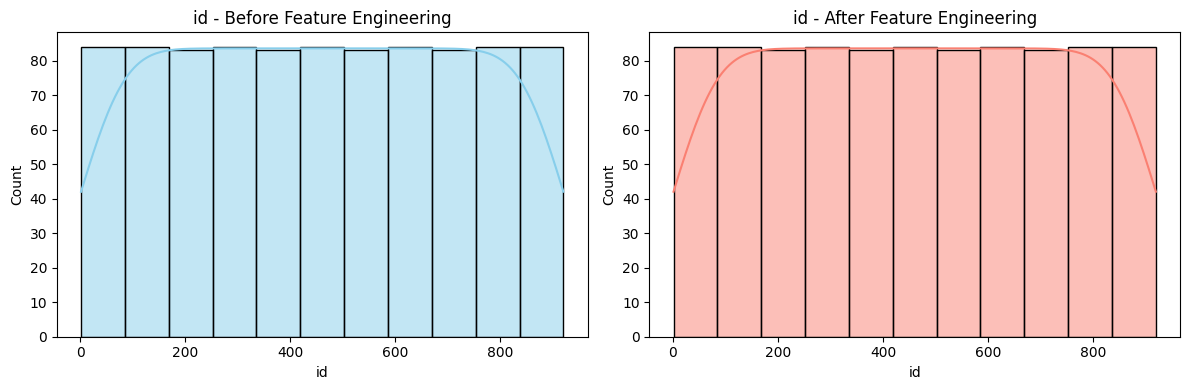

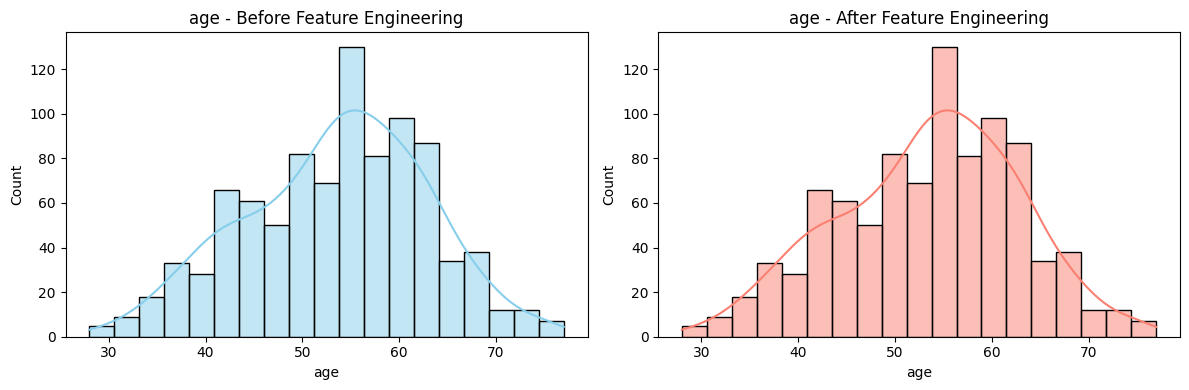

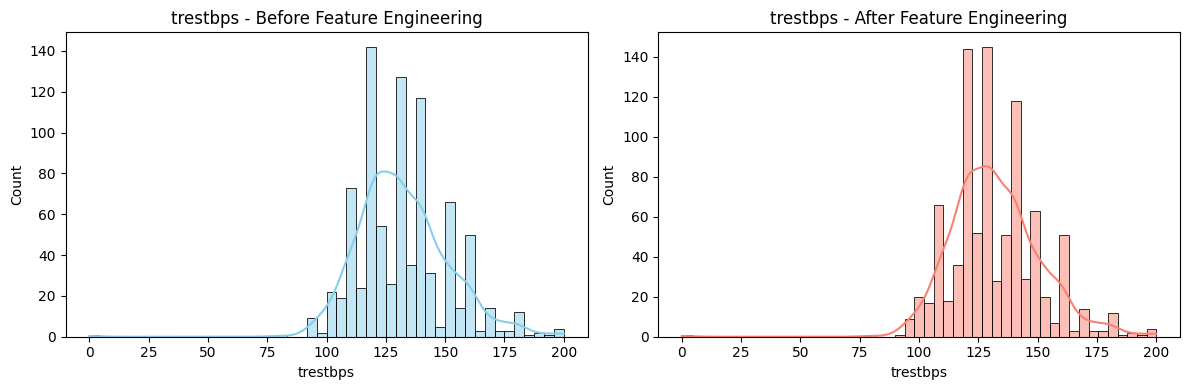

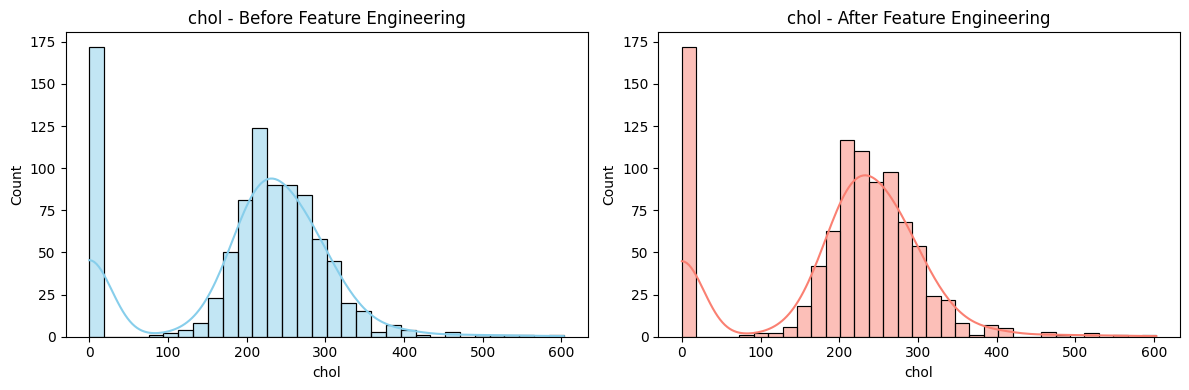

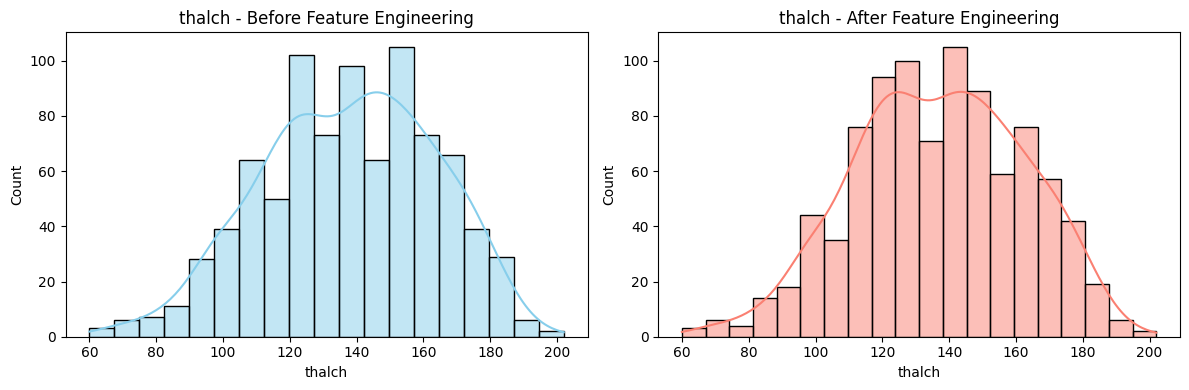

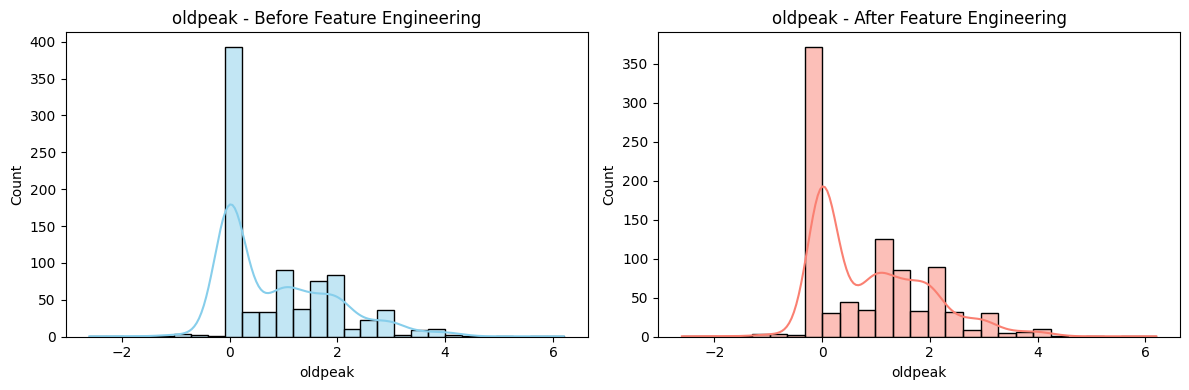

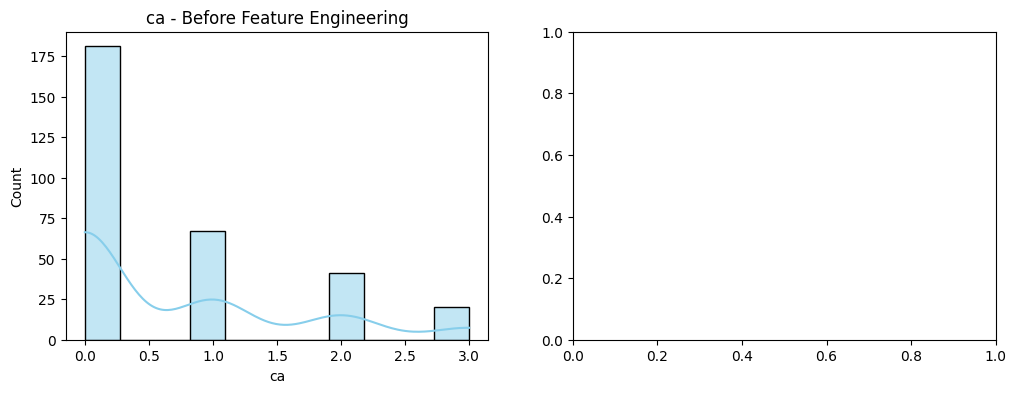

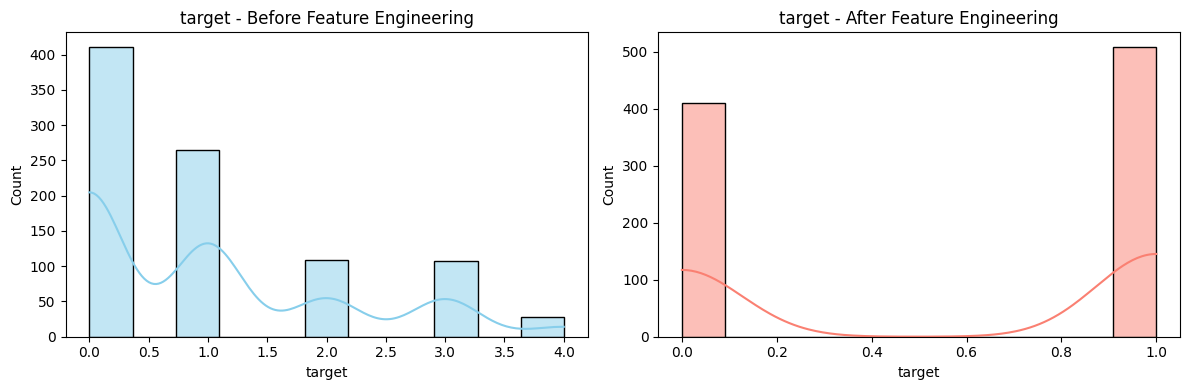

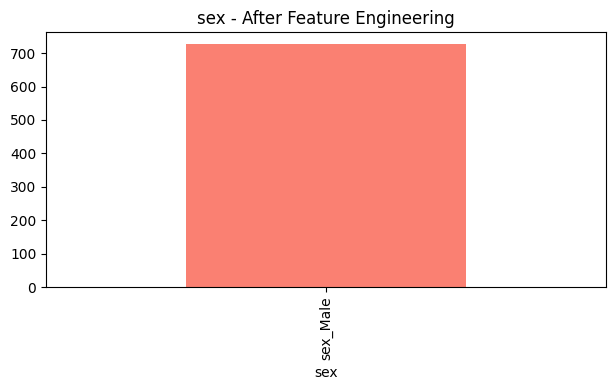

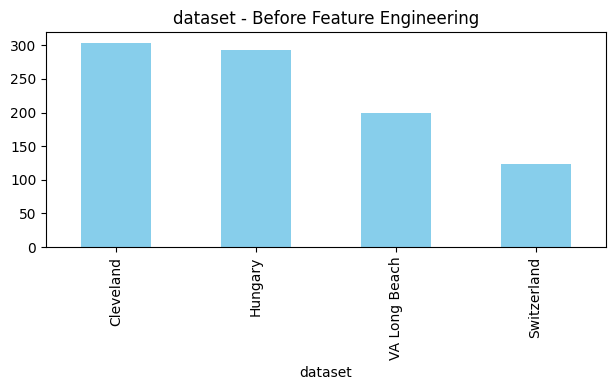

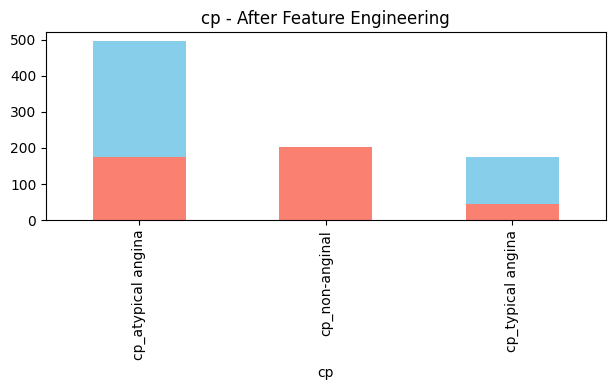

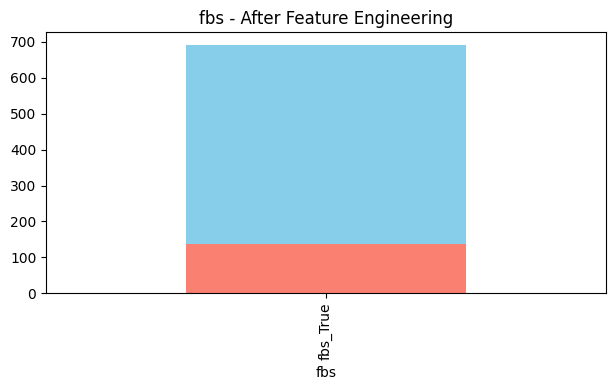

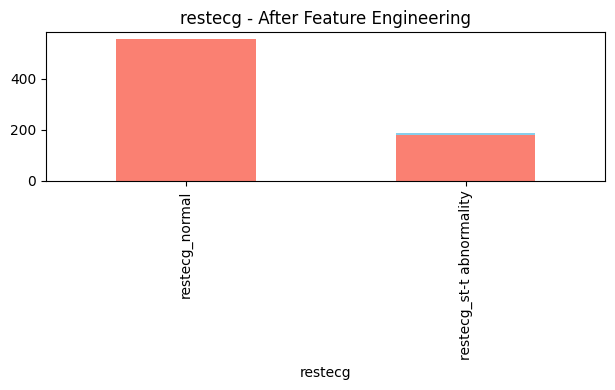

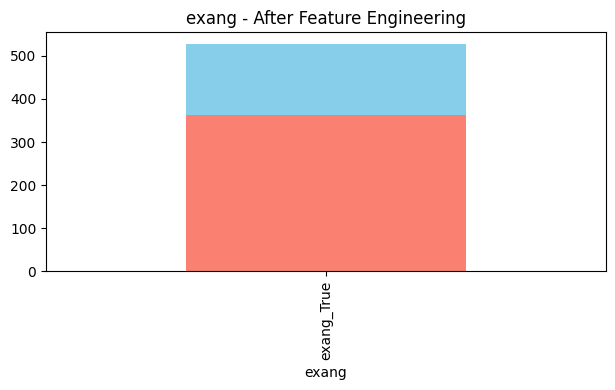

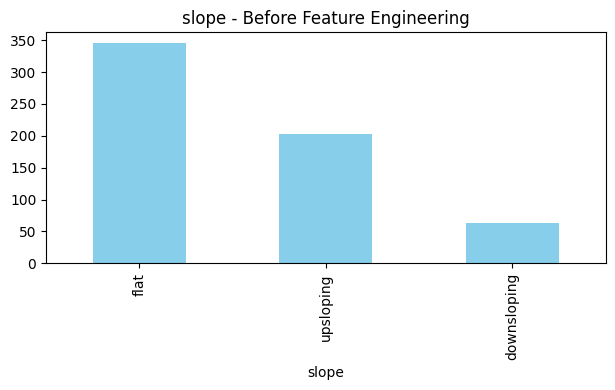

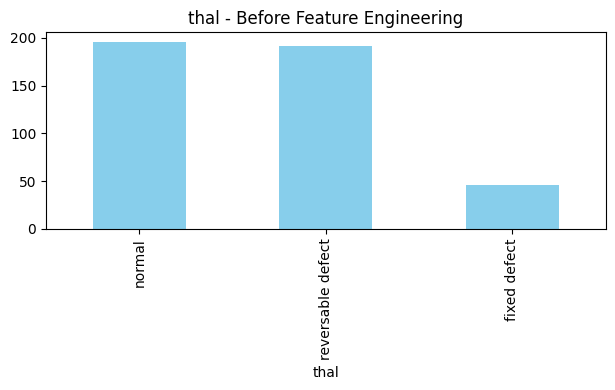

In [74]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in numerical_cols:
    plt.figure(figsize=(12,4))
    try:
        # Before feature engineering
        plt.subplot(1,2,1)
        sns.histplot(data[col], kde=True, color='skyblue')
        plt.title(f'{col} - Before Feature Engineering')
        
        # After feature engineering
        plt.subplot(1,2,2)
        sns.histplot(data_encoded[col], kde=True, color='salmon')
        plt.title(f'{col} - After Feature Engineering')
        
        plt.tight_layout()
        plt.show()
    except:
        pass

# Categorical columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    plt.figure(figsize=(12,4))
    
    # Before feature engineering
    plt.subplot(1,2,1)
    data[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'{col} - Before Feature Engineering')
    
    # After feature engineering (sum of 1s for each dummy column)
    # Find the dummy columns corresponding to this categorical column
    dummy_cols = [c for c in data_encoded.columns if c.startswith(col+'_')]
    if dummy_cols:
        (data_encoded[dummy_cols].sum()).plot(kind='bar', color='salmon')
        plt.title(f'{col} - After Feature Engineering')
    
    plt.tight_layout()
    plt.show()